## Prepare for the environment

In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestRegressor, AdaBoostRegressor, 
                              GradientBoostingRegressor, ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.cross_validation import KFold

## Feature Exploration, Engineering and Cleaning

In [2]:
trainDF=pd.read_csv("train.csv")
# observe the data
trainDF.head(3)

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0


In [3]:
# get a list of all the independent variables
cols=[c for c in trainDF.columns if 'X' in c]
# use data types to check how many quantitative variables and how many categorical variables
trainDF[cols].dtypes.value_counts()

int64     368
object      8
dtype: int64

We havev 368 quantitative variables and 8 categorical variables 

In [4]:
independent_columns=list(set(trainDF.columns) - set(['ID', 'y']))
y_train=trainDF['y'].values
x_train=trainDF[independent_columns]
testDF=pd.read_csv("test.csv")
x_test=testDF[independent_columns]

In [5]:
# Feature engineering steps for categorical variables
for column in independent_columns:
    cardinality=len(np.unique(x_train[column]))
    if cardinality==1:
        x_train.drop(column,axis=1)
        x_test.drop(column,axis=1)
    if cardinality>2:
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column]=x_train[column].apply(mapper)
        x_test[column]=x_test[column].apply(mapper)

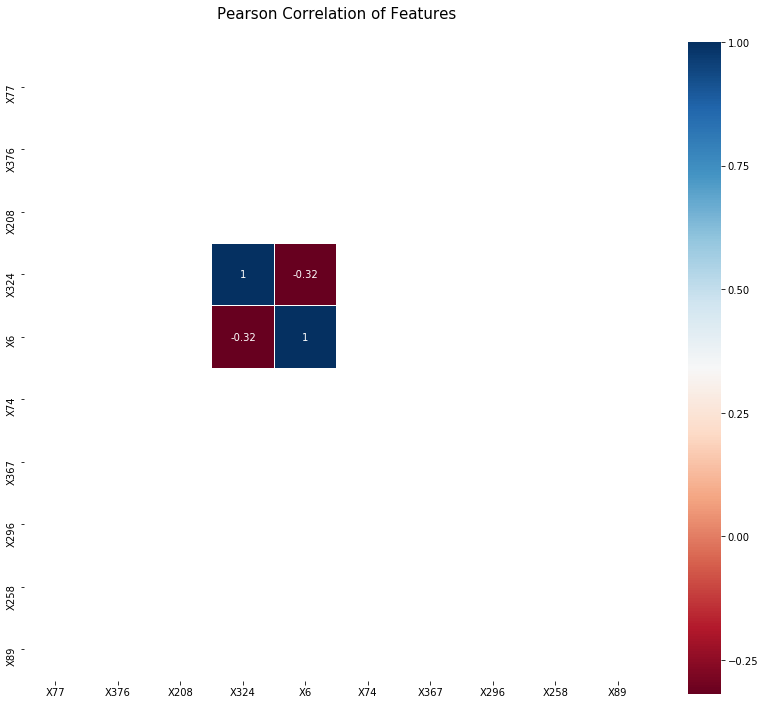

In [6]:
# Two useful tools in feature engineering
# Correlation matrix
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(x_train.iloc[1:10,15:25].astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

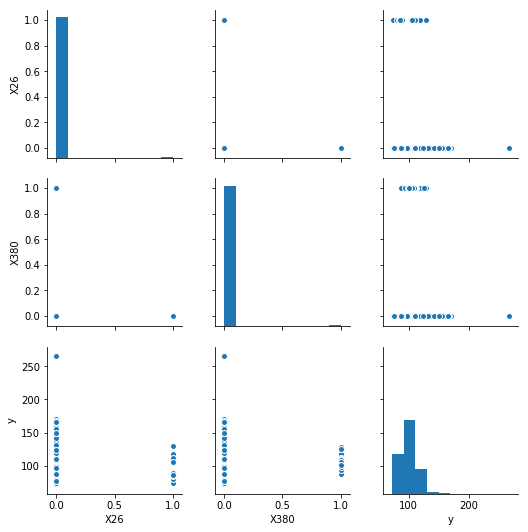

In [7]:
# pairplot
pairdf=trainDF.loc[:,['X26','X380','y']]
sns.pairplot(pairdf)

## Ensemble and Stacking Model

In [6]:
# create some useful parameters which will be used
# return the number of the rows of the training data set
ntrain=x_train.shape[0]
# return the number of rows of the test data set
ntest=x_test.shape[0]
# for reproducibility 
SEED=0
NFOLDS=5
kf=KFold(ntrain,n_folds=NFOLDS,random_state=SEED)

In [7]:
# build a class to extend the Sklearn regressor
class SklearnHelper(object):
    # def init : Python standard for invoking the default constructor for the class
    def __init__(self,reg,seed=0,params=None):
        params['random_state']=seed
        self.reg=reg(**params)
    def train(self,x_train,y_train):
        self.reg.fit(x_train,y_train)
    def predict(self,x):
        return self.reg.predict(x)
    def fit(self,x,y):
        return self.reg.fit(x,y)
    def feature_importance(self,x,y):
        print (self.reg.fit(x,y).feature_importances_)

In [8]:
# get out-of-fold predictions
def get_oof(reg, x_train, y_train, x_test):
    # create an zero array with the number of rows of train
    oof_train=np.zeros((ntrain,))
    oof_test=np.zeros((ntest,))
    oof_test_skf=np.empty((NFOLDS,ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        reg.train(x_tr, y_tr)

        oof_train[test_index] = reg.predict(x_te)
        oof_test_skf[i, :] = reg.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

## Generate base first-level models

In [9]:
# random forest regressor
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [11]:
# prepare the new data format for the cross validation
x_train=x_train.values # create an array of the train data
x_test=x_test.values # create an array of the test data

In [13]:
rf = SklearnHelper(reg=RandomForestRegressor, seed=SEED, params=rf_params)
et = SklearnHelper(reg=ExtraTreesRegressor, seed=SEED, params=et_params)
ada = SklearnHelper(reg=AdaBoostRegressor, seed=SEED, params=ada_params)
gb = SklearnHelper(reg=GradientBoostingRegressor, seed=SEED, params=gb_params)

In [15]:
# Caution it will take three minutes to finish training
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print("Training is complete")

Training is complete


In [17]:
# It will take around one minute to finish training
et_feature = et.feature_importance(x_train,y_train)

[0.00000000e+00 5.02838961e-06 1.03217926e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.07645967e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.56322352e-05
 7.07417720e-04 1.90403382e-06 0.00000000e+00 0.00000000e+00
 5.26721151e-05 9.50483273e-07 6.99353207e-07 2.37631785e-06
 8.05899249e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.33828719e-03 1.10008804e-03 0.00000000e+00
 0.00000000e+00 5.30062708e-05 1.67121362e-03 0.00000000e+00
 8.38938494e-04 5.14046274e-04 0.00000000e+00 9.55650110e-05
 1.21311222e-04 5.21731969e-05 0.00000000e+00 0.00000000e+00
 4.10179233e-02 0.00000000e+00 2.12567761e-05 3.37267411e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.69033756e-06 1.25908373e-05 0.00000000e+00
 0.00000000e+00 8.21380837e-05 5.39309115e-04 0.00000000e+00
 3.36525963e-03 1.95485738e-03 8.70509329e-03 4.95722922e-05
 0.00000000e+00 2.67412729e-04 0.00000000e+00 4.57636727e-02
 2.59043858e-03 0.000000